In [476]:
import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from lightgbm import log_evaluation, record_evaluation, early_stopping
from optuna.study import StudyDirection
from sklearn.model_selection import train_test_split
import fastparquet
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [477]:
df = pd.read_parquet('polygon_4_data_v2.parquet')

In [478]:
df.head()

,brand,model,fuel_type,mileage,year,owner_type,accidents,color,transmission,car_age,set_type,price
index,,,,,,,,,,,,
968,Lexus,GX,Gas,51271,2001,First,2,Transparent,Automatic,22,train,361263.41
848,Porsche,Macan,Hybrid,20254,2018,First,4,Black,Automatic,5,train,683604.60
974,Lexus,GX,Hybrid,55448,2009,First,0,Golden,Manual,14,train,683398.37
91,Audi,A6,Diesel,197300,2011,Third,2,Aquamarine,Automatic,12,train,11612.14
808,Volvo,XC40,Hybrid,15916,2022,First,3,Silver,Automatic,1,train,872879.46


In [479]:
count_zero_price = (df['price'] == 0).sum()

print(f"Количество машин, у которых цена равна 0: {count_zero_price}")

Количество машин, у которых цена равна 0: 36


## Обработка и кодирование данных

In [414]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 968 to 864
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         1000 non-null   object 
 1   model         1000 non-null   object 
 2   fuel_type     1000 non-null   object 
 3   mileage       1000 non-null   int64  
 4   year          1000 non-null   int64  
 5   owner_type    1000 non-null   object 
 6   accidents     1000 non-null   int64  
 7   color         1000 non-null   object 
 8   transmission  1000 non-null   object 
 9   car_age       1000 non-null   int64  
 10  set_type      1000 non-null   object 
 11  price         1000 non-null   float64
dtypes: float64(1), int64(4), object(7)
memory usage: 101.6+ KB


In [415]:
mask = df['price'] == 0
df.loc[mask, 'price'] =  1

In [416]:
categorical_features = df.select_dtypes(include=['object', 'category'])

In [417]:
for column in categorical_features.columns:
    unique_values = categorical_features[column].unique()
    print(f"{column}: {unique_values}")

brand: ['Lexus' 'Porsche' 'Audi' 'Volvo' 'Volkswagen' 'Nissan' 'BMW' 'Chevrolet'
 'Toyota' 'Mercedes' 'Subaru' 'Jaguar' 'Ford' 'Kia' 'Jeep' 'Mazda'
 'Hyundai' 'Honda' 'Land Rover' 'Tesla']
model: ['GX' 'Macan' 'A6' 'XC40' 'Atlas' 'XC60' 'Jetta' 'Leaf' 'Q5' '5 Series'
 'Malibu' 'Taycan' 'Prius' 'C-Class' 'Forester' 'Legacy' 'F-PACE'
 'Mustang' 'Impreza' 'Rogue' 'Maxima' 'Sportage' 'Corolla'
 'Grand Cherokee' 'Tiguan' 'RAV4' 'Soul' 'Mazda3' 'Camaro' 'Focus' 'CX-30'
 'Forte' 'Panamera' 'i8' 'Elantra' 'Kona' 'IS' 'Q7' 'A8' 'Renegade' 'XE'
 'NX' 'CX-5' 'Sonata' 'S-Class' 'Crosstrek' 'Camry' 'Altima' 'Mazda6'
 'F-TYPE' 'Pilot' 'HR-V' 'GLC' 'V60' '911' 'Optima' 'Santa Fe' 'Equinox'
 'I-PACE' 'Cherokee' 'RX' 'Tucson' 'Explorer' 'X3' 'A3' 'X5' 'Silverado'
 'Highlander' 'Accord' 'Sorento' 'E-Class' 'Range Rover' 'Civic'
 'Wrangler' 'Traverse' 'Passat' 'S60' 'Sentra' 'CX-9' 'Outback' 'GLE' 'ES'
 'F150' 'XC90' 'Model Y' '3 Series' 'Discovery' 'Fusion' 'Model 3' 'XF'
 'Compass' 'Golf' 'CR-V' 'Cayen

In [418]:
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

categorical_features = ['brand', 'model', 'fuel_type', 'owner_type', 'color', 'transmission']
df[categorical_features] = ordinal_encoder.fit_transform(df[categorical_features])

df.head()

,brand,model,fuel_type,mileage,year,owner_type,accidents,color,transmission,car_age,set_type,price
index,,,,,,,,,,,,
968,10.0,37.0,2.0,51271,2001,0.0,2,7.0,0.0,22,train,361263.41
848,14.0,49.0,3.0,20254,2018,0.0,4,1.0,0.0,5,train,683604.60
974,10.0,37.0,3.0,55448,2009,0.0,0,3.0,1.0,14,train,683398.37
91,0.0,4.0,0.0,197300,2011,2.0,2,0.0,0.0,12,train,11612.14
808,19.0,90.0,3.0,15916,2022,0.0,3,6.0,0.0,1,train,872879.46


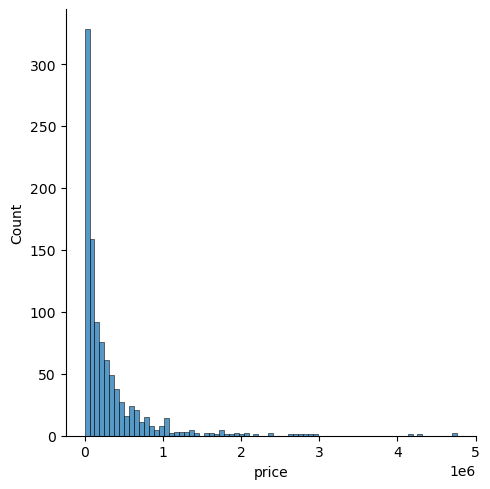

In [484]:
import seaborn as sns
sns.displot(df['price'])

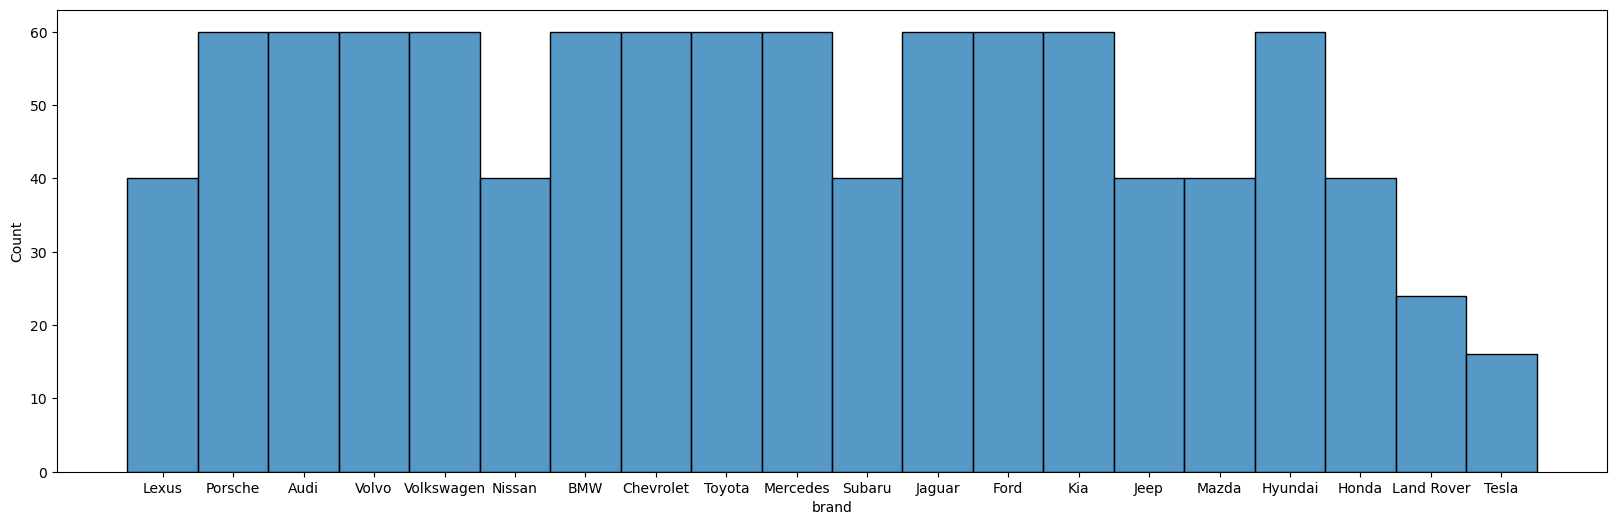

In [487]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
sns.histplot(df['brand'])
plt.show()

In [419]:
df_train = df[df['set_type'] == 'train']
df_test = df[df['set_type'] == 'test']

In [420]:
df_train.head()

,brand,model,fuel_type,mileage,year,owner_type,accidents,color,transmission,car_age,set_type,price
index,,,,,,,,,,,,
968,10.0,37.0,2.0,51271,2001,0.0,2,7.0,0.0,22,train,361263.41
848,14.0,49.0,3.0,20254,2018,0.0,4,1.0,0.0,5,train,683604.60
974,10.0,37.0,3.0,55448,2009,0.0,0,3.0,1.0,14,train,683398.37
91,0.0,4.0,0.0,197300,2011,2.0,2,0.0,0.0,12,train,11612.14
808,19.0,90.0,3.0,15916,2022,0.0,3,6.0,0.0,1,train,872879.46


In [421]:
df_test

,brand,model,fuel_type,mileage,year,owner_type,accidents,color,transmission,car_age,set_type,price
index,,,,,,,,,,,,
36,1.0,1.0,2.0,70725,2009,2.0,2,2.0,1.0,14,test,258513.54
307,13.0,72.0,2.0,138272,2016,0.0,2,6.0,1.0,7,test,134440.02
330,13.0,51.0,2.0,176890,2016,2.0,2,7.0,1.0,7,test,37219.79
281,17.0,68.0,1.0,34855,2015,1.0,2,6.0,1.0,8,test,448694.99
755,8.0,33.0,1.0,60284,2002,2.0,2,2.0,1.0,21,test,73186.03
...,...,...,...,...,...,...,...,...,...,...,...,...
235,4.0,40.0,3.0,115078,1995,2.0,3,3.0,0.0,28,test,1.00
219,4.0,6.0,3.0,130657,2004,0.0,0,0.0,0.0,19,test,214278.37
719,8.0,80.0,1.0,43413,2012,1.0,2,4.0,1.0,11,test,230961.28


In [422]:
val_size = len(df_test)

In [423]:
df_train, df_val = train_test_split(df_train, test_size=val_size, random_state=42)

In [424]:
X_train = df_train.drop(columns=['price', 'set_type'])
y_train = df_train['price']
X_val = df_val.drop(columns=['price', 'set_type'])
y_val = df_val['price']
X_test = df_test.drop(columns=['price', 'set_type'])
y_test = df_test['price']

In [425]:
print(f"Train size: {len(df_train)}, Val size: {len(df_val)}, Test size: {len(df_test)}")

Train size: 600, Val size: 200, Test size: 200


In [426]:
# y_test = y_test[y_test != 0]
# y_val =  y_val[y_val != 0]
# y_train = y_train[y_train != 0] 

In [427]:
df_test

,brand,model,fuel_type,mileage,year,owner_type,accidents,color,transmission,car_age,set_type,price
index,,,,,,,,,,,,
36,1.0,1.0,2.0,70725,2009,2.0,2,2.0,1.0,14,test,258513.54
307,13.0,72.0,2.0,138272,2016,0.0,2,6.0,1.0,7,test,134440.02
330,13.0,51.0,2.0,176890,2016,2.0,2,7.0,1.0,7,test,37219.79
281,17.0,68.0,1.0,34855,2015,1.0,2,6.0,1.0,8,test,448694.99
755,8.0,33.0,1.0,60284,2002,2.0,2,2.0,1.0,21,test,73186.03
...,...,...,...,...,...,...,...,...,...,...,...,...
235,4.0,40.0,3.0,115078,1995,2.0,3,3.0,0.0,28,test,1.00
219,4.0,6.0,3.0,130657,2004,0.0,0,0.0,0.0,19,test,214278.37
719,8.0,80.0,1.0,43413,2012,1.0,2,4.0,1.0,11,test,230961.28


In [428]:
model = lgbm.LGBMRegressor()
model.fit(X_train, y_train)

LGBMRegressor()

In [429]:
y_val_pred = model.predict(X_val)

In [430]:
y_val[y_val==0]

Series([], Name: price, dtype: float64)

In [431]:
mae_val = mean_absolute_error(y_val, y_val_pred)
mape_val = mean_absolute_percentage_error(y_val, y_val_pred)
print(f'Validation MAE: {mae_val}')
print(f'Validation MAPE: {mape_val * 100:.2f}%')

Validation MAE: 145802.2865384189
Validation MAPE: 345986.60%


In [432]:
y_test_pred = model.predict(X_test)

In [433]:
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
print(f'Test MAE: {mae_test}')
print(f'Test MAPE: {mape_test * 100:.2f}%')

Test MAE: 140939.25456812358
Test MAPE: 588550.25%


In [434]:
df['price'].describe()

count    1.000000e+03
mean     3.027662e+05
std      4.890482e+05
min      1.000000e+00
25%      4.067822e+04
50%      1.344142e+05
75%      3.593099e+05
max      4.765622e+06
Name: price, dtype: float64

In [470]:
hyperparams = {
    'learning_rate': 0.1,
    'n_estimators': 100,
    'max_depth': -1,

    'min_child_samples': 1,

    'min_split_gain': 0,

    'reg_alpha': 0,
    'reg_lambda': 0,

    'verbose': -1
}

lgbm_regressor = lgbm.LGBMRegressor(**hyperparams)
lgbm_regressor = lgbm_regressor.fit(X_train, y_train)

y_pred_lgbm = lgbm_regressor.predict(X_test)

# 5. Расчет MAE
mae = mean_absolute_error(y_test, y_pred_lgbm)

# 6. Расчет MAPE
mape = np.mean(np.abs((y_test - y_pred_lgbm) / y_test)) * 100

# Вывод результатов
print("Mean Absolute Error (MAE):", mae)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Absolute Error (MAE): 136593.84288129339
Mean Absolute Percentage Error (MAPE): 512131.38%


In [436]:
params = {
    'num_leaves': 100,
    'max_depth': -1,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
}

In [437]:
model_1 = lgbm.LGBMRegressor(**params)
model_1.fit(X_train, y_train)

# Оцените производительность
y_test_pred = model.predict(X_test)
mae_test_1 = mean_absolute_error(y_test, y_test_pred)
mape_test_1 = mean_absolute_percentage_error(y_test, y_test_pred)
print(f'Test MAE: {mae_test_1}')
print(f'Test MAPE: {mape_test_1 * 100:.2f}%')

Test MAE: 140939.25456812358
Test MAPE: 588550.25%


In [438]:
def objective(trial):
    params = {
        'objective': 'regression',
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),  # Оптимизируем num_leaves
        'max_depth': trial.suggest_int('max_depth', -1, 10),  # -1 для неограниченной глубины
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Оптимизируем
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Оптимизируем
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 1.0),  # Оптимизируем
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 1.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 1.0),
    }


    model_2 = lgbm.LGBMRegressor(**params)
    model_2.fit(X_train, y_train)

    # Предсказание на валидационной выборке
    y_val_pred = model_2.predict(X_val)
    
    # Вычисление MAPE и MAE
    mape = mean_absolute_percentage_error(y_val, y_val_pred)

    return mape

In [439]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1500)

# Вывод лучших параметров и значений MAPE и MAE
best_params = study.best_params
best_mape = study.best_value * 100  # Переводим в проценты


[I 2025-05-23 16:33:07,633] A new study created in memory with name: no-name-a55fe1dd-7189-44e4-a568-6f7d97c1a490
C:\Users\Каролина\AppData\Local\Temp\ipykernel_11596\3677761265.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1),
C:\Users\Каролина\AppData\Local\Temp\ipykernel_11596\3677761265.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 1.0),  # Оптимизируем
C:\Users\Каролина\AppData\Local\Temp\ipykernel_11596\3677761265.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See htt

In [440]:
# Best parameters and evaluation
print("Best hyperparameters:", study.best_params)
print(f"Best MAPE: {study.best_value*100:.2f}%")


Best hyperparameters: {'num_leaves': 82, 'max_depth': 0, 'learning_rate': 0.021579119190900258, 'n_estimators': 154, 'subsample': 0.98213671176566, 'colsample_bytree': 0.5354824382055464, 'reg_alpha': 0.09405660242159661, 'lambda_l1': 0.0016127615971963025, 'lambda_l2': 0.03221796201614645}
Best MAPE: 162446.60%


In [441]:
best_model = lgbm.LGBMRegressor(**best_params)
best_model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.5354824382055464,
              lambda_l1=0.0016127615971963025, lambda_l2=0.03221796201614645,
              learning_rate=0.021579119190900258, max_depth=0, n_estimators=154,
              num_leaves=82, reg_alpha=0.09405660242159661,
              subsample=0.98213671176566)

In [471]:
y_val_pred = best_model.predict(X_val)
best_mae = mean_absolute_error(y_val, y_val_pred)

print(f"Best MAPE: {best_mape:.2f}%")  # Выводим MAPE в процентах
print(f"Best MAE: {best_mae:.2f}")

Best MAPE: 162446.60%
Best MAE: 149761.85


In [443]:
y_test_pred = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

print(f'Test MAE: {test_mae}')
print(f'Test MAPE: {test_mape * 100:.2f}%')

Test MAE: 158696.20314045865
Test MAPE: 485982.66%


## XGBoost

In [444]:
from xgboost import XGBRegressor

In [445]:
df_XGB = XGBRegressor()
df_XGB.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [446]:
y_val_predict_XGB = df_XGB.predict(X_val)

In [447]:
y_test_predict_XGB = df_XGB.predict(X_test)

In [ ]:
print("Base MAE:", mean_absolute_error(y_val, y_val_predict_XGB))

Base MAE: 164447.04333596036


In [ ]:
print("Base MAE:", mean_absolute_error(y_test, y_test_predict_XGB))

Base MAE: 133791.62733494875


In [472]:
mape_test_1 = mean_absolute_percentage_error(y_test, y_test_predict_XGB)
print("Test MAE:", mean_absolute_error(y_test, y_test_predict_XGB))
print(f'Test MAPE: {mape_test_1 * 100:.2f}%')

Test MAE: 133791.62733494875
Test MAPE: 599578.47%


## SHAP

In [451]:
import shap

In [481]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

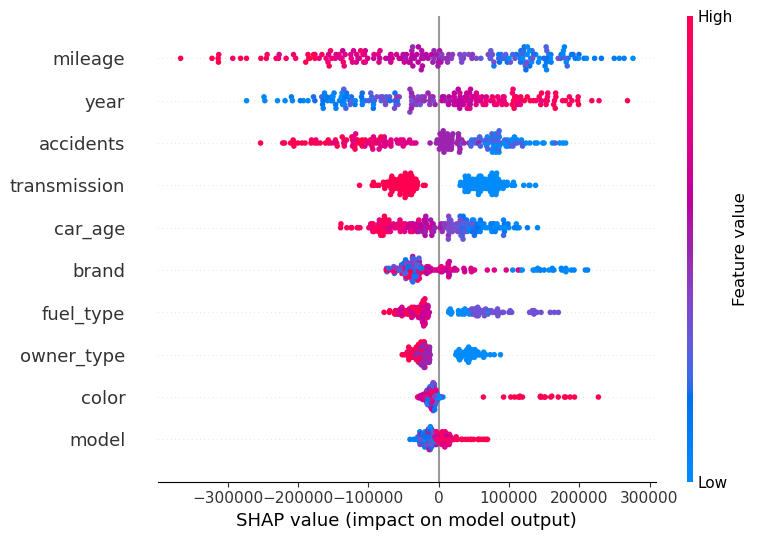

In [482]:
shap.summary_plot(shap_values_lgbm, X_test)

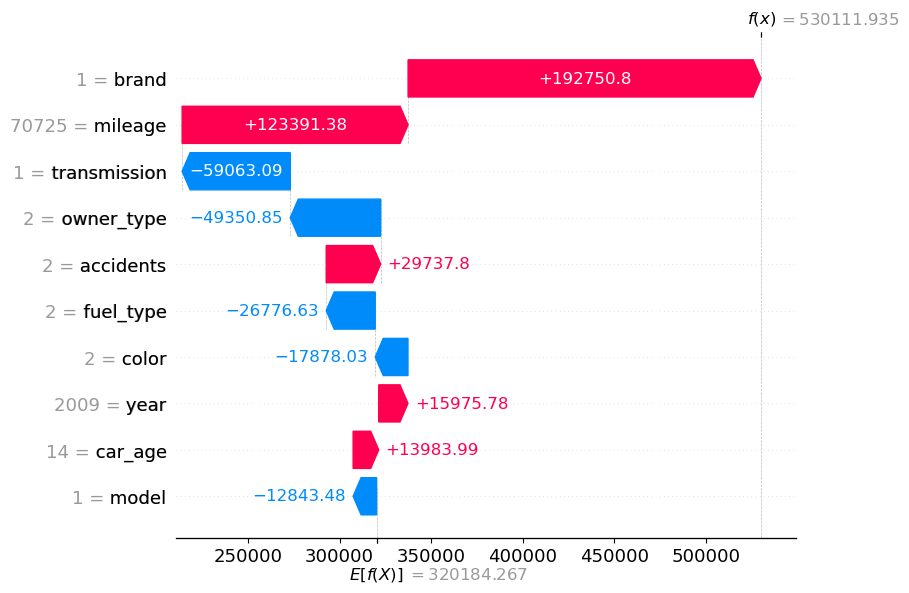

In [483]:
shap.plots.waterfall(shap_values_lgbm[0])

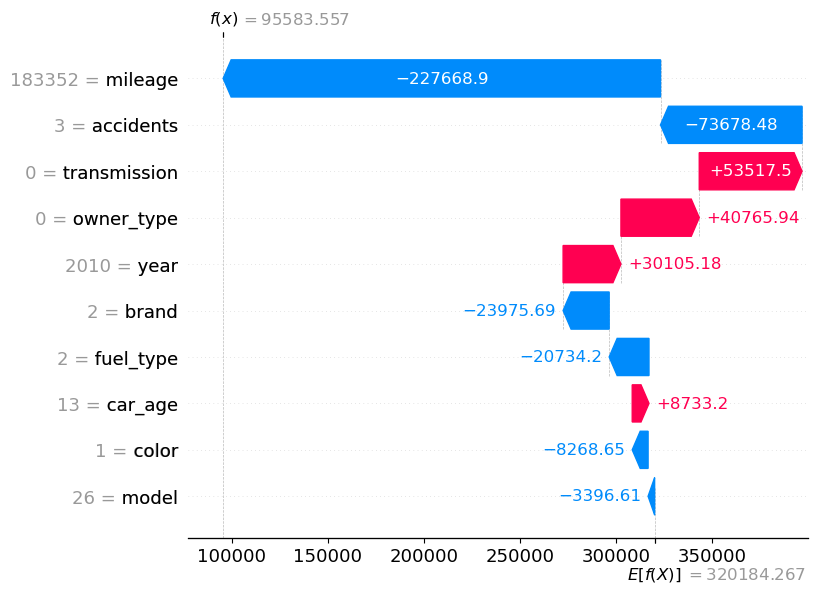

In [468]:
shap.plots.waterfall(shap_values_lgbm[18])